Demonstration of randomized search to compare classifier performance
============================================================================
An important step in classifier performance comparison is hyperparameter 
optimization. Here, we specify the classifer models we want to tune and a 
dictionary of hyperparameter ranges (preferably similar for fairness in 
comparision) for each classifier. Then, we find the optimal hyperparameters 
through a function that uses RandomizedSearchCV and refit the optimized 
models to obtain accuracies. We can see clearly in the plot that the 
optimized models perform better than or similar to the default parameter models. On the 
dataset we use in this example, car dataset from OpenML-CC18, SPORF also 
performs better than RF overall. 


In [1]:
print(__doc__)

from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import math
from rerf.rerfClassifier import rerfClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import metrics

from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

import matplotlib
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


In [2]:
def hyperparameter_optimization_random(X, y, *argv):
    """
    Given a classifier and a dictionary of hyperparameters, find optimal hyperparameters using RandomizedSearchCV.

    Parameters
    ----------
    X : numpy.ndarray
        Input data, shape (n_samples, n_features)
    y : numpy.ndarray
        Output data, shape (n_samples, n_outputs)
    *argv : list of tuples (classifier, hyperparameters)
        List of (classifier, hyperparameters) tuples:

        classifier : sklearn-compliant classifier
            For example sklearn.ensemble.RandomForestRegressor, rerf.rerfClassifier, etc
        hyperparameters : dictionary of hyperparameter ranges
            See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html.

    Returns
    -------
    clf_best_params : dictionary
        Dictionary of best hyperparameters
    """

    clf_best_params = {}

    # Iterate over all (classifier, hyperparameters) pairs
    for clf, params in argv:

        # Run randomized search
        n_iter_search = 10
        random_search = RandomizedSearchCV(
            clf, param_distributions=params, n_iter=n_iter_search, cv=10, iid=False
        )
        random_search.fit(X, y)

        # Save results
        clf_best_params[clf] = random_search.best_params_

    return clf_best_params

# Building classifiers and specifying parameter ranges to sample from


In [3]:
# get some data
X, y = fetch_openml(data_id=40975, return_X_y=True, as_frame=True) #car dataset
y = pd.factorize(y)[0]
X = X.apply(lambda x: pd.factorize(x)[0])
n_features = np.shape(X)[1]
n_samples = np.shape(X)[0]

# build a classifier
rerf = rerfClassifier()

# specify max_depth and min_sample_splits ranges
max_depth_array_rerf = (np.unique(np.round((np.linspace(2, n_samples, 10))))).astype(
    int
)
max_depth_range_rerf = np.append(max_depth_array_rerf, None)

min_sample_splits_range_rerf = (
    np.unique(
        np.round((np.arange(1, math.log(n_samples), (math.log(n_samples) - 2) / 10)))
    )
).astype(int)

# specify parameters and distributions to sample from
rerf_param_dict = {
    "n_estimators": np.arange(50, 550, 50),
    "max_depth": max_depth_range_rerf,
    "min_samples_split": min_sample_splits_range_rerf,
    "feature_combinations": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", None, n_features ** 2],
}

# build another classifier
rf = RandomForestClassifier()

# specify max_depth and min_sample_splits ranges
max_depth_array_rf = (np.unique(np.round((np.linspace(2, n_samples, 10))))).astype(int)
max_depth_range_rf = np.append(max_depth_array_rf, None)

min_sample_splits_range_rf = (
    np.unique(
        np.round((np.arange(2, math.log(n_samples), (math.log(n_samples) - 2) / 10)))
    )
).astype(int)

# specify parameters and distributions to sample from
rf_param_dict = {
    "n_estimators": np.arange(50, 550, 50),
    "max_depth": max_depth_range_rf,
    "min_samples_split": min_sample_splits_range_rf,
    "max_features": ["sqrt", "log2", None],
}

# Obtaining best parameters dictionary and refitting

In [4]:
best_params = hyperparameter_optimization_random(
    X, y, (rerf, rerf_param_dict), (rf, rf_param_dict)
)
print(best_params)

# extract values from dict - seperate each classifier's param dict
keys, values = zip(*best_params.items())

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# get accuracies of optimized and default models
rerf_opti = rerfClassifier(**values[0])
rerf_opti.fit(X_train, y_train)
rerf_pred_opti = rerf_opti.predict(X_test)
rerf_acc_opti = metrics.accuracy_score(y_test, rerf_pred_opti)

rerf_default = rerfClassifier()
rerf_default.fit(X_train, y_train)
rerf_pred_default = rerf_default.predict(X_test)
rerf_acc_default = metrics.accuracy_score(y_test, rerf_pred_default)

rf_opti = RandomForestClassifier(**values[1])
rf_opti.fit(X_train, y_train)
rf_pred_opti = rf_opti.predict(X_test)
rf_acc_opti = metrics.accuracy_score(y_test, rf_pred_opti)

rf_default = RandomForestClassifier()
rf_default.fit(X_train, y_train)
rf_pred_default = rf_default.predict(X_test)
rf_acc_default = metrics.accuracy_score(y_test, rf_pred_default)

{rerfClassifier(feature_combinations=1.5, image_height=None, image_width=None,
               max_depth=None, max_features='auto', min_samples_split=1,
               n_estimators=500, n_jobs=None, oob_score=False,
               patch_height_max=None, patch_height_min=1, patch_width_max=None,
               patch_width_min=1, projection_matrix='RerF', random_state=None): {'n_estimators': 300, 'min_samples_split': 4, 'max_features': 36, 'max_depth': 577, 'feature_combinations': 2}, RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                  

# Plotting the result

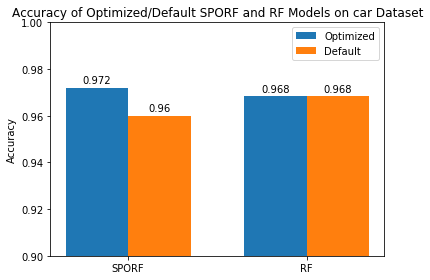

In [5]:
labels = ["SPORF", "RF"]
rerf_acc = [rerf_acc_opti, rerf_acc_default]
rf_acc = [rf_acc_opti, rf_acc_default]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, rerf_acc, width, label="Optimized")
rects2 = ax.bar(x + width / 2, rf_acc, width, label="Default")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of Optimized/Default SPORF and RF Models on car Dataset")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = float("%.3f" % (rect.get_height()))
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.ylim((0.9, 1))

plt.show()